In [72]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WESAD/S2/S2_E4_Data/ACC.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "orvile/wesad-wearable-stress-affect-detection-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:\n", df.head())

First 5 records:
    1495437325.000000   1495437325.000000   1495437325.000000.1
0               32.0                32.0                  32.0
1               29.0                -6.0                  55.0
2               28.0                -6.0                  55.0
3               28.0                -6.0                  55.0
4               28.0                -6.0                  55.0


In [73]:
import pickle
import numpy as np
import pandas as pd
from scipy.signal import resample
import kagglehub

# -------------------------
# LISTA DE SUJETOS A CARGAR
# -------------------------
subjects = ["S2", "S3", "S4", "S5", "S6", "S7",
            "S8", "S9", "S10", "S11", "S13",
            "S14", "S15", "S16", "S17"]

def load_subject(subject):
    """Carga un sujeto, procesa sus señales y retorna un DataFrame."""
    print(f"Procesando {subject} ...")

    # Descargar archivo pkl de KaggleHub
    path = kagglehub.dataset_download(
        "orvile/wesad-wearable-stress-affect-detection-dataset",
        f"WESAD/{subject}/{subject}.pkl"
    )

    with open(path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    # Señales del reloj
    acc  = np.array(data["signal"]["wrist"]["ACC"])     # Nx3 @32Hz
    bvp  = np.array(data["signal"]["wrist"]["BVP"]).squeeze()   # Nx1 @64Hz
    eda  = np.array(data["signal"]["wrist"]["EDA"]).squeeze()   # Nx1 @4Hz
    temp = np.array(data["signal"]["wrist"]["TEMP"]).squeeze()  # Nx1 @4Hz

    labels = np.array(data["label"])  # 700Hz
    L = len(labels)

    # Re-sample todas las señales a 700Hz
    acc_rs  = resample(acc,  L)
    bvp_rs  = resample(bvp,  L)
    eda_rs  = resample(eda,  L)
    temp_rs = resample(temp, L)

    # Solo estrés/no estrés
    stress_bin = np.where(labels == 2, 1, 0)

    df = pd.DataFrame({
        "subject": subject,
        "acc_x": acc_rs[:, 0],
        "acc_y": acc_rs[:, 1],
        "acc_z": acc_rs[:, 2],
        "bvp":   bvp_rs,
        "eda":   eda_rs,
        "temp":  temp_rs,
        "stress": stress_bin
    })

    return df


# --------------------------------------------
# Cargar y unir TODOS los sujetos en un dataset
# --------------------------------------------
all_dfs = []

for sbj in subjects:
    try:
        df = load_subject(sbj)
        all_dfs.append(df)
    except Exception as e:
        print(f"Error en {sbj}: {e}")

df_full = pd.concat(all_dfs, ignore_index=True)

print("\nDataset combinado listo!")
print(df_full.shape)
print(df_full["stress"].value_counts())
df_full.head()


Procesando S2 ...
Procesando S3 ...
Procesando S4 ...
Procesando S5 ...
Procesando S6 ...
Procesando S7 ...
Procesando S8 ...
Procesando S9 ...
Procesando S10 ...
Procesando S11 ...
Procesando S13 ...
Procesando S14 ...
Procesando S15 ...
Procesando S16 ...
Procesando S17 ...

Dataset combinado listo!
(60807600, 8)
stress
0    53831399
1     6976201
Name: count, dtype: int64


,subject,acc_x,acc_y,acc_z,bvp,eda,temp,stress
0,S2,62.000000,-21.000000,107.000000,-59.370000,1.138257,35.410000,0
1,S2,62.307282,-21.156211,109.270362,-63.580766,1.142849,35.414642,0
2,S2,62.639848,-21.033768,111.011770,-66.580843,1.147382,35.419221,0
3,S2,62.995836,-20.638036,112.206895,-68.365462,1.151857,35.423735,0
4,S2,63.372326,-19.977788,112.844950,-68.985094,1.156272,35.428185,0


In [74]:
def get_stress_segments(df):
    """
    Retorna únicamente las filas donde stress == 1.
    """
    return df[df["stress"] == 1].reset_index(drop=True)
df_stress = get_stress_segments(df_full)
print(df_stress.head())
print(df_stress.shape)


  subject      acc_x      acc_y      acc_z         bvp       eda       temp  \
0      S2  13.439926 -52.379183  13.541135 -241.017702  0.775691  34.069856   
1      S2  13.828004 -52.455848  13.466781 -235.157796  0.775715  34.069852   
2      S2  14.209912 -52.532774  13.392612 -229.384873  0.775741  34.069848   
3      S2  14.582169 -52.608284  13.320201 -223.701984  0.775767  34.069844   
4      S2  14.941483 -52.680771  13.251144 -218.111837  0.775796  34.069840   

   stress  
0       1  
1       1  
2       1  
3       1  
4       1  
(6976201, 8)


In [75]:
import numpy as np
import pandas as pd

def window_reduce(df, hz=700, window_seconds=1):
    window = hz * window_seconds

    # dejar solo columnas NUMÉRICAS
    df_num = df.select_dtypes(include=[np.number])

    # cortar exceso para que sea divisible
    usable = (len(df_num) // window) * window
    df_num = df_num.iloc[:usable]

    # agrupar por ventana
    df_windowed = df_num.groupby(df_num.index // window).mean()

    # etiqueta binaria: basta un 1 dentro de la ventana
    df_windowed["stress"] = (
        df_num["stress"].groupby(df_num.index // window).max()
    )

    return df_windowed

df_reduced = window_reduce(df_full)

print(df_reduced.shape)
df_reduced


(86868, 7)


,acc_x,acc_y,acc_z,bvp,eda,temp,stress
0,51.976955,14.231976,28.649323,31.610494,1.068864,35.424470,0
1,55.877680,17.799241,24.395516,-16.107955,0.943409,35.411521,0
2,53.857164,22.171009,23.503597,-23.577625,1.155373,35.410588,0
3,53.384052,20.450312,27.180465,23.834969,1.292975,35.412379,0
4,53.785876,20.282777,26.803075,-10.903197,1.251165,35.428338,0
...,...,...,...,...,...,...,...
86863,-58.494999,9.180915,-5.010963,-4.118116,0.851749,31.832497,0
86864,-53.270878,-36.357195,-4.146985,-2.275416,0.823334,31.830760,0
86865,-52.473065,-37.917879,-5.222609,-0.784753,0.808060,31.813099,0
86866,-52.119191,-38.161129,-4.022418,6.420120,0.794579,31.812974,0


In [76]:
print(df_reduced["stress"].value_counts())


stress
0    76887
1     9981
Name: count, dtype: int64


In [77]:
# Si hay valores nulos, imputar con la media usando sklearn
from sklearn.impute import SimpleImputer

# Manejo de valores nulos para df_full
print("Valores nulos en df_full:")
print(df_full.isnull().sum())

if df_full.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    df_full_imputed = pd.DataFrame(imputer.fit_transform(df_full), columns=df_full.columns)
    print("Valores nulos imputados en df_full")
else:
    df_full_imputed = df_full.copy()
    print("No hay valores nulos en df_full")

Valores nulos en df_full:
subject    0
acc_x      0
acc_y      0
acc_z      0
bvp        0
eda        0
temp       0
stress     0
dtype: int64
No hay valores nulos en df_full


In [78]:
# Manejo de valores nulos para df_reduced
print("Valores nulos en df_reduced:")
print(df_reduced.isnull().sum())

if df_reduced.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    df_reduced_imputed = pd.DataFrame(imputer.fit_transform(df_reduced), columns=df_reduced.columns)
    print("Valores nulos imputados en df_reduced")
else:
    df_reduced_imputed = df_reduced.copy()
    print("No hay valores nulos en df_reduced")

Valores nulos en df_reduced:
acc_x     0
acc_y     0
acc_z     0
bvp       0
eda       0
temp      0
stress    0
dtype: int64
No hay valores nulos en df_reduced


In [79]:
# Preparar variables predictoras y objetivo para df_full
from sklearn.model_selection import train_test_split

X_full = df_full_imputed.drop(['subject', 'stress'], axis=1)
y_full = df_full_imputed['stress']

# Dividir en conjuntos de entrenamiento y prueba
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, 
    test_size=0.3,       
    random_state=42,     
    stratify=y_full          
)

print("df_full - X_train shape:", X_full_train.shape)
print("df_full - X_test shape:", X_full_test.shape)
print("df_full - y_train distribution:", y_full_train.value_counts())
print("df_full - y_test distribution:", y_full_test.value_counts())

df_full - X_train shape: (42565320, 6)
df_full - X_test shape: (18242280, 6)
df_full - y_train distribution: stress
0    37681979
1     4883341
Name: count, dtype: int64
df_full - y_test distribution: stress
0    16149420
1     2092860
Name: count, dtype: int64


In [80]:
# Preparar variables predictoras y objetivo para df_reduced
X_reduced = df_reduced_imputed.drop(['stress'], axis=1)
y_reduced = df_reduced_imputed['stress']

# Dividir en conjuntos de entrenamiento y prueba
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, y_reduced, 
    test_size=0.3,       
    random_state=42,     
    stratify=y_reduced          
)

print("df_reduced - X_train shape:", X_reduced_train.shape)
print("df_reduced - X_test shape:", X_reduced_test.shape)
print("df_reduced - y_train distribution:", y_reduced_train.value_counts())
print("df_reduced - y_test distribution:", y_reduced_test.value_counts())

df_reduced - X_train shape: (60807, 6)
df_reduced - X_test shape: (26061, 6)
df_reduced - y_train distribution: stress
0    53820
1     6987
Name: count, dtype: int64
df_reduced - y_test distribution: stress
0    23067
1     2994
Name: count, dtype: int64


In [81]:
# Escalamiento de Datos con StandardScaler

from sklearn.preprocessing import StandardScaler

# Escalar datos para df_reduced
scaler_reduced = StandardScaler()
X_reduced_train_scaled = scaler_reduced.fit_transform(X_reduced_train)
X_reduced_test_scaled = scaler_reduced.transform(X_reduced_test)

print("\nEscalamiento completado para df_reduced")
print(f"Forma de X_reduced_train_scaled: {X_reduced_train_scaled.shape}")
print(f"Forma de X_reduced_test_scaled: {X_reduced_test_scaled.shape}")


Escalamiento completado para df_reduced
Forma de X_reduced_train_scaled: (60807, 6)
Forma de X_reduced_test_scaled: (26061, 6)


In [82]:
# Importar modelos y métricas
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier  # Para algoritmos de conjuntos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Función para evaluar un modelo
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name, use_scaled=False, scaler=None):
    
    print(f"\nEvaluando {model_name} en {dataset_name}")
    if use_scaled:
        print("(Usando datos escalados)")
        if scaler is None:
            raise ValueError("No se han proporcionado datos escalados")
        
        # Escalar los datos
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Usar datos escalados
        X_train_to_use = X_train_scaled
        X_test_to_use = X_test_scaled
    else:
        # Usar datos originales
        X_train_to_use = X_train
        X_test_to_use = X_test
    
    # Entrenar y predecir
    model.fit(X_train_to_use, y_train)
    y_pred = model.predict(X_test_to_use)
    
    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    
    # Mostrar resultados
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    return {
        'Model': model_name,
        'Dataset': dataset_name,
        'Scaled': use_scaled,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    }

In [83]:
# Definir los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42)  # Ajustado para velocidad en dataset grande
    # SVM omitido por tiempo de ejecución en df_full
}

# Nota: SVM se omite para df_full debido al tamaño del dataset (puede tomar mucho tiempo). Se puede agregar si se desea.

# Lista para almacenar resultados
results = []

# Evaluar en df_reduced
for name, model in models.items():
    
    if name in ['Logistic Regression', 'KNN', 'Naive Bayes']:
        # Usar escalado para estos modelos
        scaler = StandardScaler()
        result = evaluate_model(
            model, X_reduced_train, X_reduced_test, 
            y_reduced_train, y_reduced_test, 
            f"{name} (scaled)", 'df_reduced',
            use_scaled=True, scaler=scaler
        )
    else:
        # No usar escalado ya que no lo requieren
        result = evaluate_model(
            model, X_reduced_train, X_reduced_test, 
            y_reduced_train, y_reduced_test, 
            name, 'df_reduced',
            use_scaled=False
        )
    
    results.append(result)

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
print("\nResumen de resultados:")
print(results_df.sort_values('Accuracy', ascending=False).to_string(index=False))


Evaluando Logistic Regression (scaled) en df_reduced
(Usando datos escalados)
Accuracy: 0.8882
Precision: 0.6202
Recall: 0.0698
F1-Score: 0.1255
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     23067
           1       0.62      0.07      0.13      2994

    accuracy                           0.89     26061
   macro avg       0.76      0.53      0.53     26061
weighted avg       0.86      0.89      0.85     26061


Evaluando Decision Tree en df_reduced
Accuracy: 0.9896
Precision: 0.9552
Recall: 0.9542
F1-Score: 0.9547
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23067
           1       0.96      0.95      0.95      2994

    accuracy                           0.99     26061
   macro avg       0.97      0.97      0.97     26061
weighted avg       0.99      0.99      0.99     26061


Evaluando KNN (scaled) en df_reduced
(Usando da

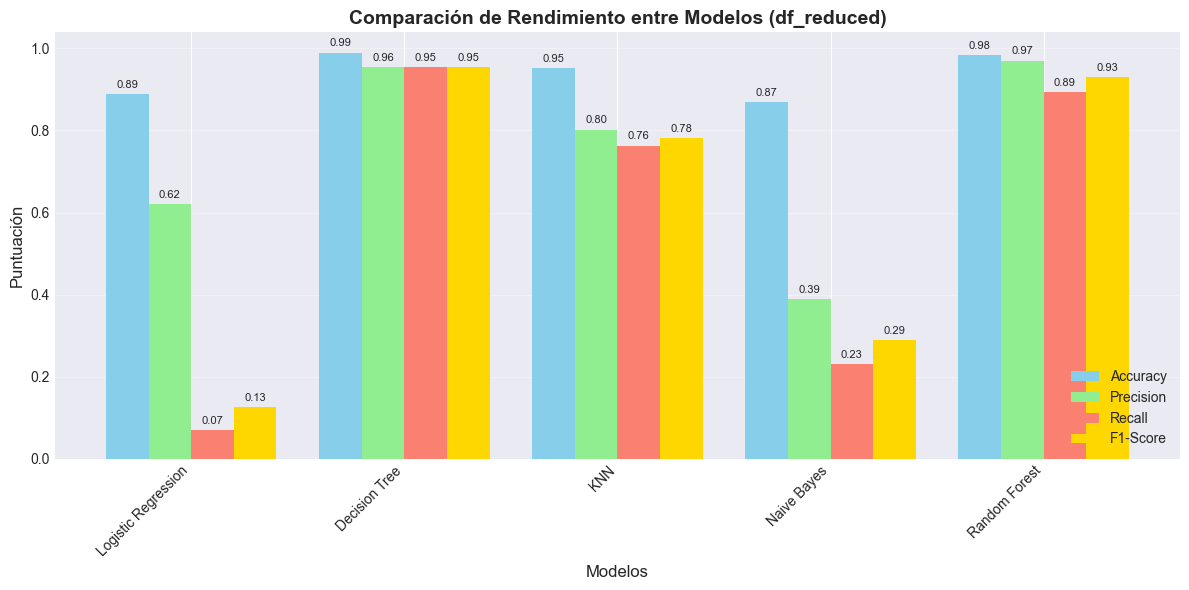

In [ ]:
# Creacion de Graficos

# 1. Comparacion de Rendimiento entre modelos usando df reduced

import matplotlib.pyplot as plt
import numpy as np

model_names = ['Logistic Regression', 'Decision Tree', 'KNN', 'Naive Bayes', 'Random Forest']
accuracy = [0.8882, 0.9896, 0.9512, 0.8700, 0.9846]
precision = [0.6202, 0.9552, 0.8023, 0.3893, 0.9702]
recall = [0.0698, 0.9542, 0.7632, 0.2315, 0.8931]
f1 = [0.1255, 0.9547, 0.7823, 0.2903, 0.9301]

x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision', color='lightgreen')
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall', color='salmon')
bars4 = ax.bar(x + 1.5*width, f1, width, label='F1-Score', color='gold')

ax.set_xlabel('Modelos', fontsize=12)
ax.set_ylabel('Puntuación', fontsize=12)
ax.set_title('Comparación de Rendimiento entre Modelos (df_reduced)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Entrenando modelos y calculando curvas ROC...
  Procesando Logistic Regression...
    AUC para Logistic Regression: 0.7528
  Procesando Decision Tree...
    AUC para Decision Tree: 0.9742
  Procesando KNN...
    AUC para KNN: 0.9413
  Procesando Naive Bayes...
    AUC para Naive Bayes: 0.7844
  Procesando Random Forest...
    AUC para Random Forest: 0.9971


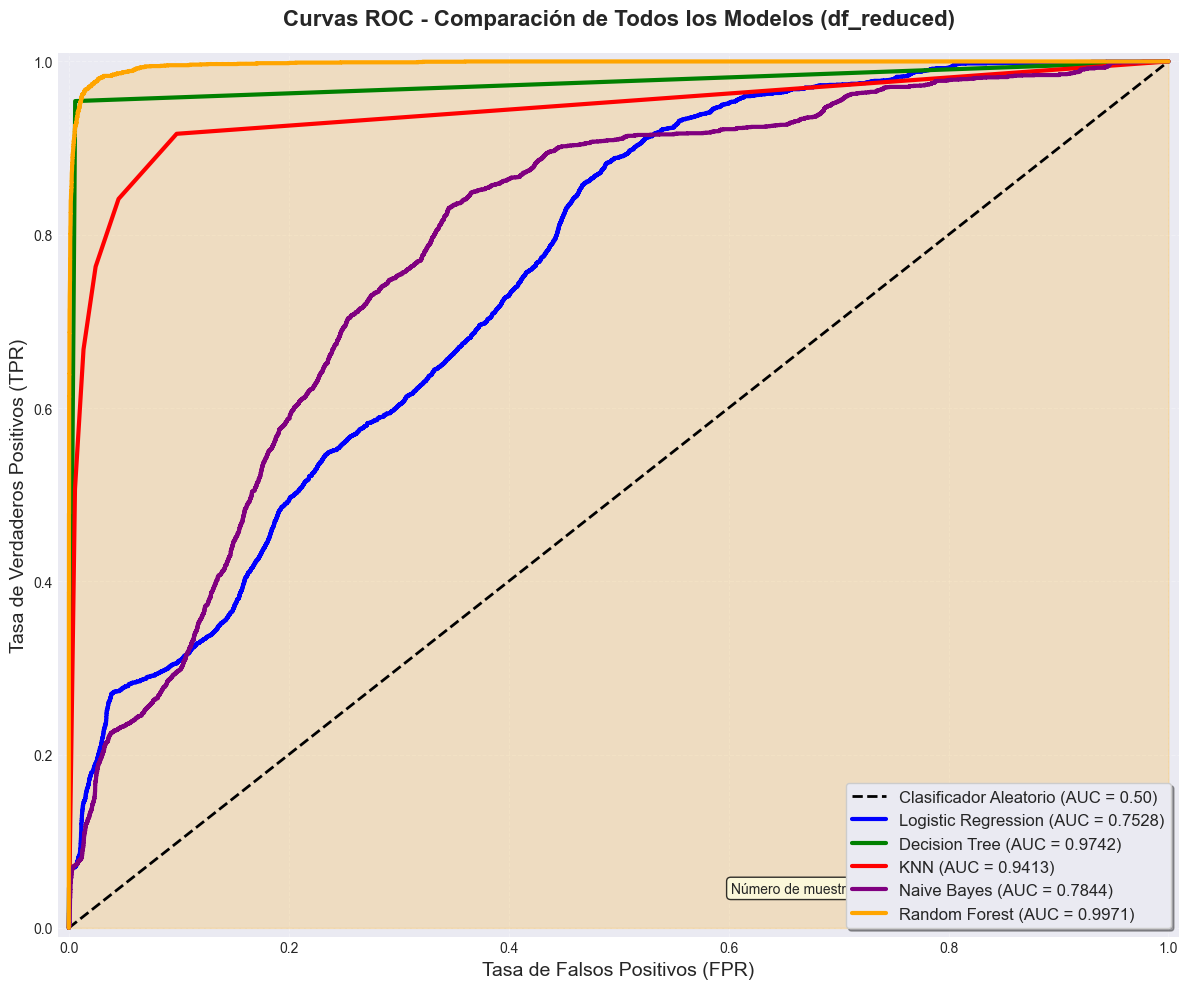

In [86]:
#2. Grafico de AUC ROC, evaluacion de los modelos

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
}

# Diccionario para almacenar las curvas ROC de cada modelo
models_roc = {}

print("Entrenando modelos y calculando curvas ROC...")

# Entrenar cada modelo y calcular su curva ROC
for model_name, model in models.items():
    print(f"  Procesando {model_name}...")
    
    # Entrenar el modelo
    model.fit(X_reduced_train, y_reduced_train)
    
    # Obtener probabilidades para la clase positiva
    # Algunos modelos como Naive Bayes y Logistic Regression tienen predict_proba
    # KNeighbors también lo tiene
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_reduced_test)[:, 1]
    else:
        # Si el modelo no tiene predict_proba, usar decision_function o scores
        # En este caso, todos los modelos seleccionados tienen predict_proba
        y_prob = model.predict_proba(X_reduced_test)[:, 1]
    
    # Calcular curva ROC y AUC
    fpr, tpr, _ = roc_curve(y_reduced_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Guardar resultados
    models_roc[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'y_prob': y_prob
    }
    
    print(f"    AUC para {model_name}: {roc_auc:.4f}")

# Crear la grafica ROC comparativa
fig, ax = plt.subplots(figsize=(12, 10))

# Linea diagonal de referencia (clasificador aleatorio)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Clasificador Aleatorio (AUC = 0.50)')

# Colores para cada modelo
colors = {
    'Logistic Regression': 'blue',
    'Decision Tree': 'green',
    'KNN': 'red',
    'Naive Bayes': 'purple',
    'Random Forest': 'orange'
}

# curva ROC para cada modelo
for model_name, roc_data in models_roc.items():
    ax.plot(roc_data['fpr'], roc_data['tpr'], 
            color=colors.get(model_name, 'gray'),
            linewidth=3,
            label=f'{model_name} (AUC = {roc_data["roc_auc"]:.4f})')

# Configurar la grafica
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
ax.set_title('Curvas ROC - Comparación de Todos los Modelos (df_reduced)', 
             fontsize=16, fontweight='bold', pad=20)

# cuadrícula
ax.grid(True, alpha=0.3, linestyle='--')

# Leyenda
ax.legend(loc='lower right', fontsize=12, frameon=True, fancybox=True, shadow=True)

# Establecer limites
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])

# texto informativo
ax.text(0.6, 0.05, f'Número de muestras: {len(X_reduced_test):,}', 
        transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", 
        facecolor="lightyellow", alpha=0.8))

best_model = max(models_roc.items(), key=lambda x: x[1]['roc_auc'])
best_model_name = best_model[0]
best_roc_data = best_model[1]

# Sombreado del área bajo la curva del mejor modelo
ax.fill_between(best_roc_data['fpr'], best_roc_data['tpr'], alpha=0.2, 
                color=colors.get(best_model_name, 'blue'),
                label=f'Área bajo curva de {best_model_name}')

plt.tight_layout()
plt.show()


In [87]:
# Funcion que permite identificar intervalos de tiempo en lso que se produce estres de acuerdo a los diferntes parametros contenidos en el dataset.

def identificar_intervalos_estres(df, min_duracion=10):
    #Identifica intervalos de tiempo donde se presenta estrés en el dataframe

    if 'stress' not in df.columns:
        raise ValueError("El DataFrame debe contener la columna 'stress'")
    
    # Identificar cambios en el estado de estrés
    cambios = df['stress'].diff()
    inicios_estres = cambios[cambios == 1].index.tolist()
    fin_estres = cambios[cambios == -1].index.tolist()
    
    # Si el primer dato es estrés
    if len(df) > 0 and df.iloc[0]['stress'] == 1:
        inicios_estres.insert(0, 0)
    
    # Si termina en estrés
    if len(df) > 0 and df.iloc[-1]['stress'] == 1:
        fin_estres.append(len(df) - 1)
    
    # Crear intervalos
    intervalos = []
    for inicio, fin in zip(inicios_estres, fin_estres):
        duracion = fin - inicio
        if duracion >= min_duracion:
            intervalos.append((inicio, fin))
    
    return intervalos

ANÁLISIS DE LOS 3 INTERVALOS DE ESTRÉS MÁS LARGOS

Se encontraron 15 intervalos de estrés:
  Intervalo 1 (LARGO): muestras 51443-52169 (duración: 726 muestras)
  Intervalo 2 (LARGO): muestras 84460-85184 (duración: 724 muestras)
  Intervalo 3 (LARGO): muestras 73164-73851 (duración: 687 muestras)
  Intervalo 4: muestras 55654-56335 (duración: 681 muestras)
  Intervalo 5: muestras 66421-67097 (duración: 676 muestras)
  Intervalo 6: muestras 77305-77979 (duración: 674 muestras)
  Intervalo 7: muestras 40854-41525 (duración: 671 muestras)
  Intervalo 8: muestras 62240-62905 (duración: 665 muestras)
  Intervalo 9: muestras 27693-28344 (duración: 651 muestras)
  Intervalo 10: muestras 22597-23243 (duración: 646 muestras)
  ... y 5 intervalos más

INTERVALO 1 de 3

ANÁLISIS DETALLADO DEL INTERVALO 1
Intervalo: muestras 51443 a 52169 (duración: 726 muestras)


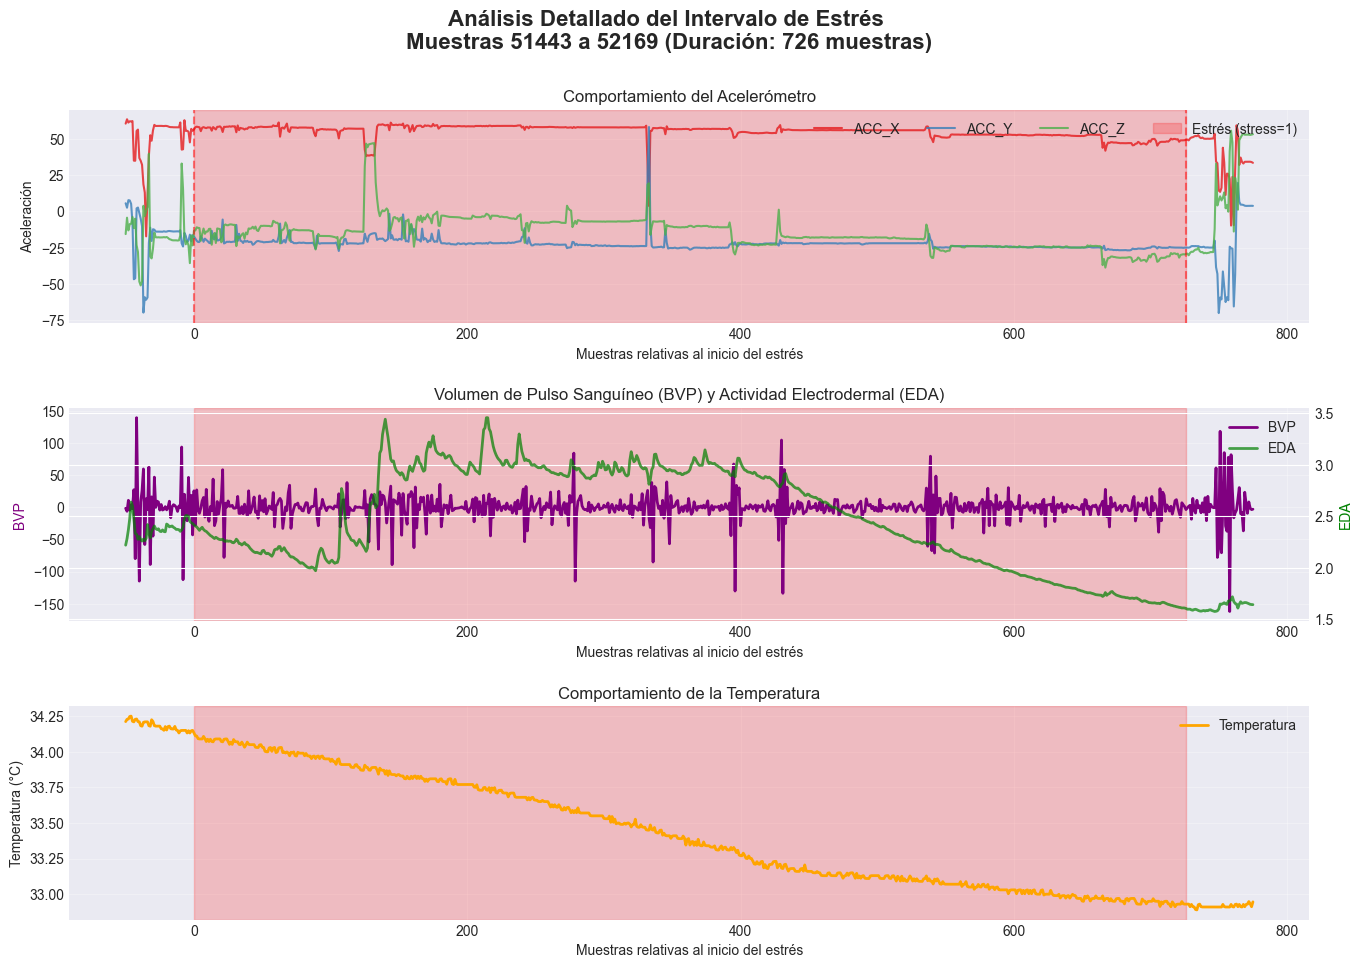


ANÁLISIS ESTADÍSTICO DETALLADO

Duración de cada período:
  Antes del estrés: 50 muestras
  Durante el estrés: 727 muestras
  Después del estrés: 49 muestras

ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO:

ACC_X:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      50.58      16.06      -17.25     63.57     
Durante    55.30      4.31       3.76       61.38     
Después    38.05      15.95      -9.79      59.39     

ACC_Y:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      -16.94     17.12      -69.88     7.74      
Durante    -22.34     4.57       -27.35     58.21     
Después    -23.92     22.50      -70.19     19.62     

ACC_Z:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      -15.96     16.33      -51.13     39.82     
Durante    -15.09     11.07      -38.82     47.06     
Después    5.47    

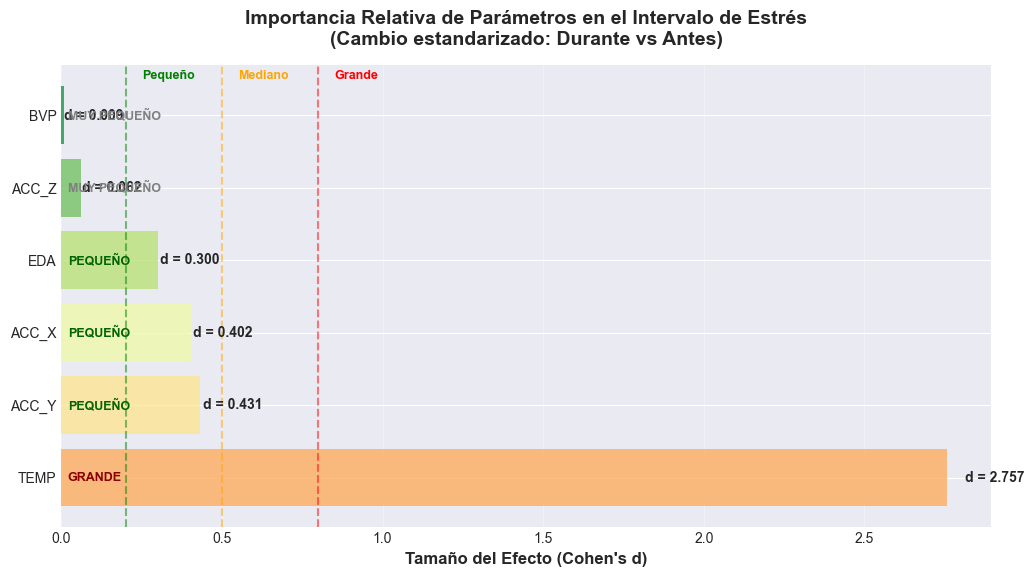


RESUMEN DE IMPORTANCIA PARA ESTE INTERVALO:
TEMP: d = 2.757 → MUY IMPORTANTE
ACC_Y: d = 0.431 → MODERADAMENTE IMPORTANTE
ACC_X: d = 0.402 → MODERADAMENTE IMPORTANTE
EDA: d = 0.300 → MODERADAMENTE IMPORTANTE
ACC_Z: d = 0.062 → POCO IMPORTANTE
BVP: d = 0.009 → POCO IMPORTANTE

INTERVALO 2 de 3

ANÁLISIS DETALLADO DEL INTERVALO 1
Intervalo: muestras 84460 a 85184 (duración: 724 muestras)


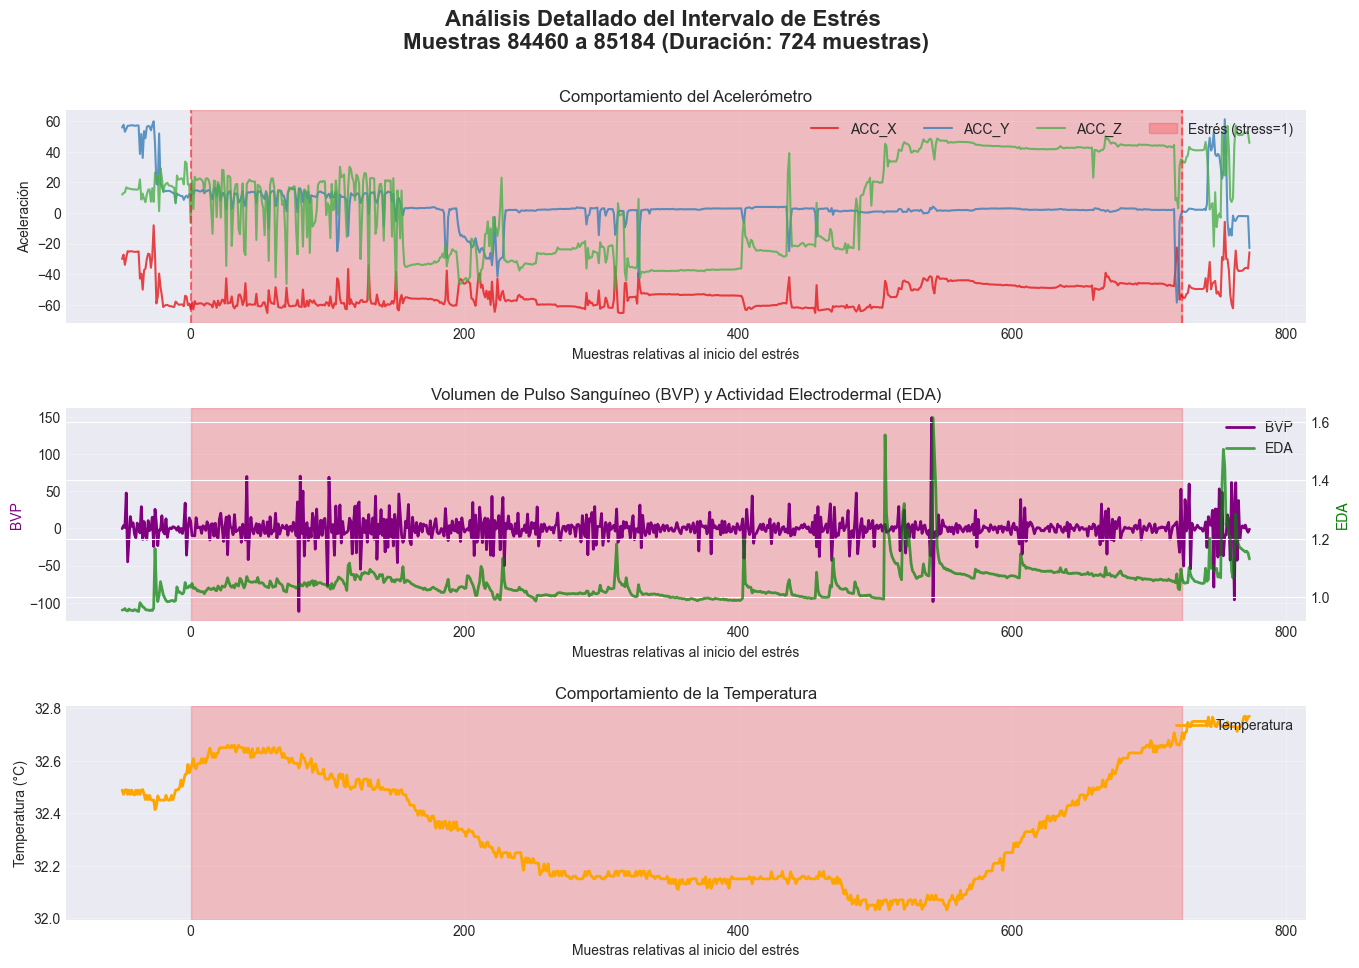


ANÁLISIS ESTADÍSTICO DETALLADO

Duración de cada período:
  Antes del estrés: 50 muestras
  Durante el estrés: 725 muestras
  Después del estrés: 49 muestras

ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO:

ACC_X:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      -43.75     15.83      -61.50     -8.02     
Durante    -54.33     6.72       -65.47     -22.59    
Después    -43.52     10.71      -62.37     -5.79     

ACC_Y:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      34.49      21.09      6.82       60.02     
Durante    2.29       8.67       -58.59     18.37     
Después    10.21      20.30      -22.99     61.36     

ACC_Z:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      17.11      6.38       1.19       33.68     
Durante    2.46       32.49      -56.52     50.33     
Después    33.18   

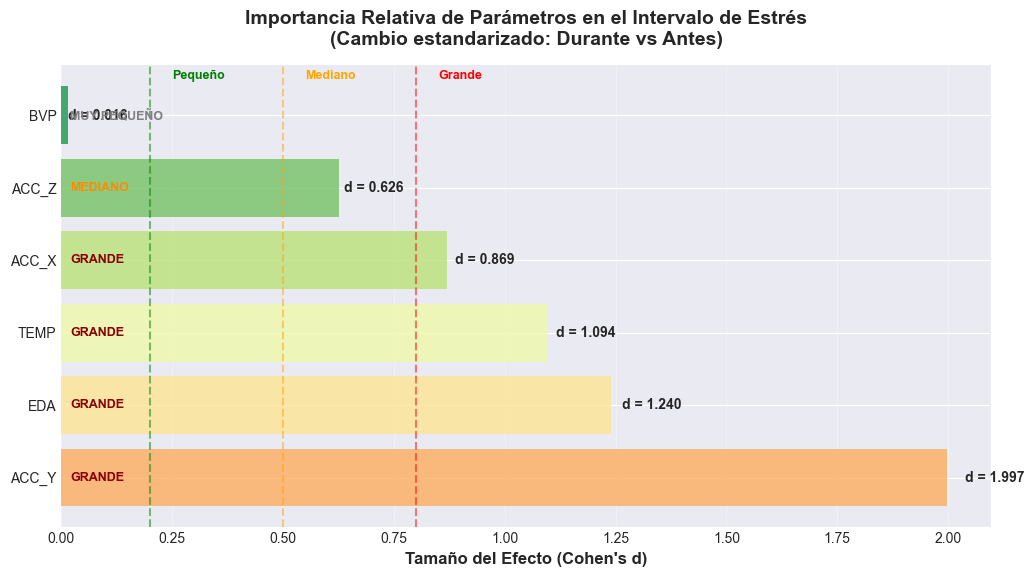


RESUMEN DE IMPORTANCIA PARA ESTE INTERVALO:
ACC_Y: d = 1.997 → MUY IMPORTANTE
EDA: d = 1.240 → MUY IMPORTANTE
TEMP: d = 1.094 → MUY IMPORTANTE
ACC_X: d = 0.869 → MUY IMPORTANTE
ACC_Z: d = 0.626 → IMPORTANTE
BVP: d = 0.016 → POCO IMPORTANTE

INTERVALO 3 de 3

ANÁLISIS DETALLADO DEL INTERVALO 1
Intervalo: muestras 73164 a 73851 (duración: 687 muestras)


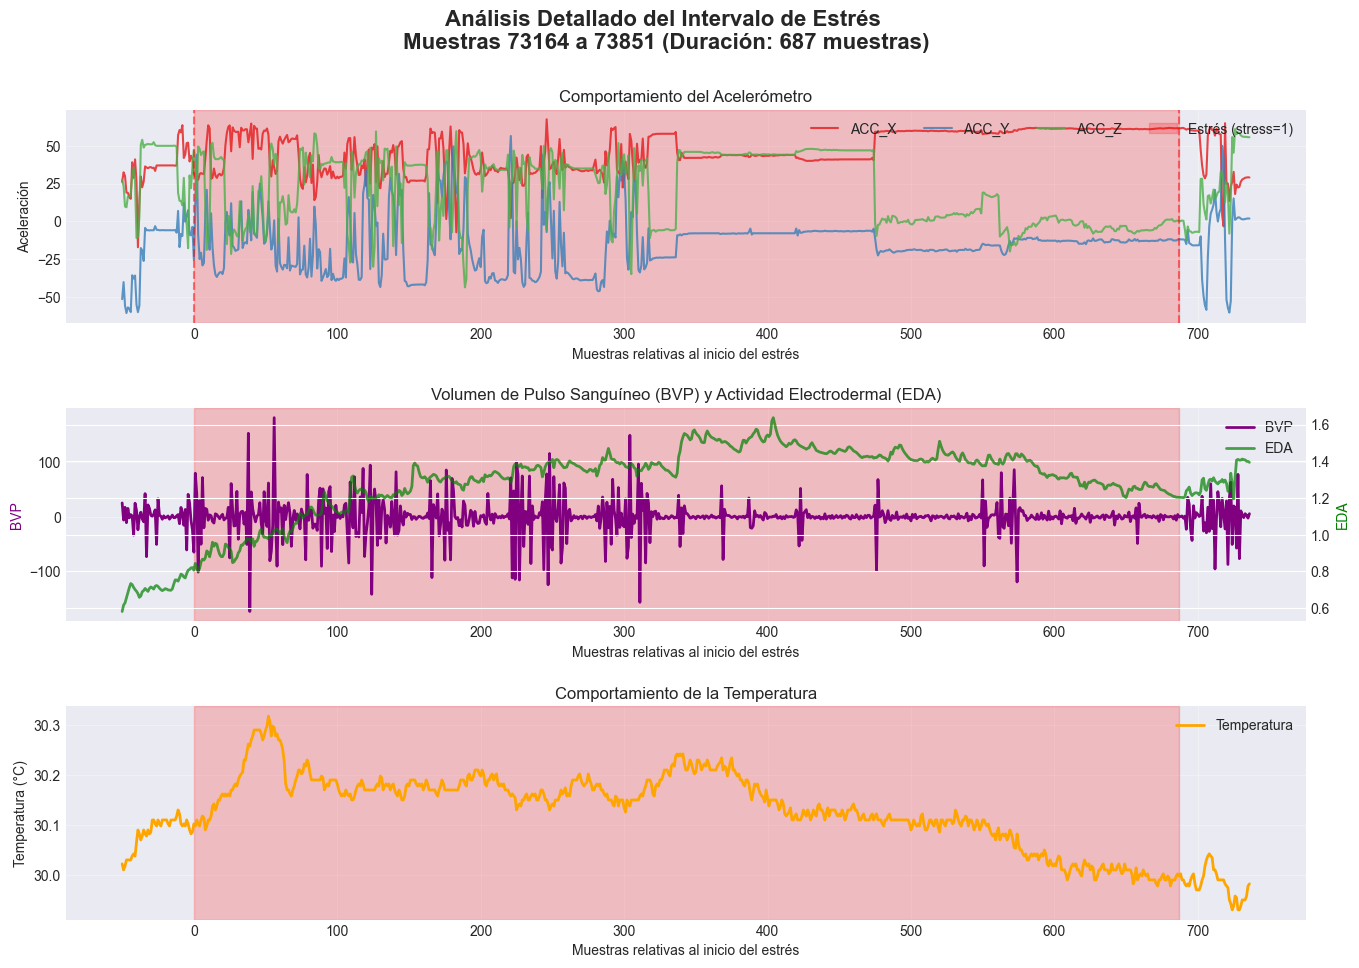


ANÁLISIS ESTADÍSTICO DETALLADO

Duración de cada período:
  Antes del estrés: 50 muestras
  Durante el estrés: 688 muestras
  Después del estrés: 49 muestras

ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO:

ACC_X:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      35.17      13.15      -17.29     63.67     
Durante    46.94      12.87      -7.36      67.61     
Después    43.17      19.12      -3.39      65.01     

ACC_Y:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      -17.83     21.43      -60.92     12.27     
Durante    -14.47     16.86      -46.49     56.53     
Después    -9.77      23.88      -60.62     49.98     

ACC_Z:
Período    Media      Std        Min        Max       
--------------------------------------------------
Antes      33.26      20.70      -17.90     54.03     
Durante    20.74      22.68      -43.86     59.67     
Después    21.03   

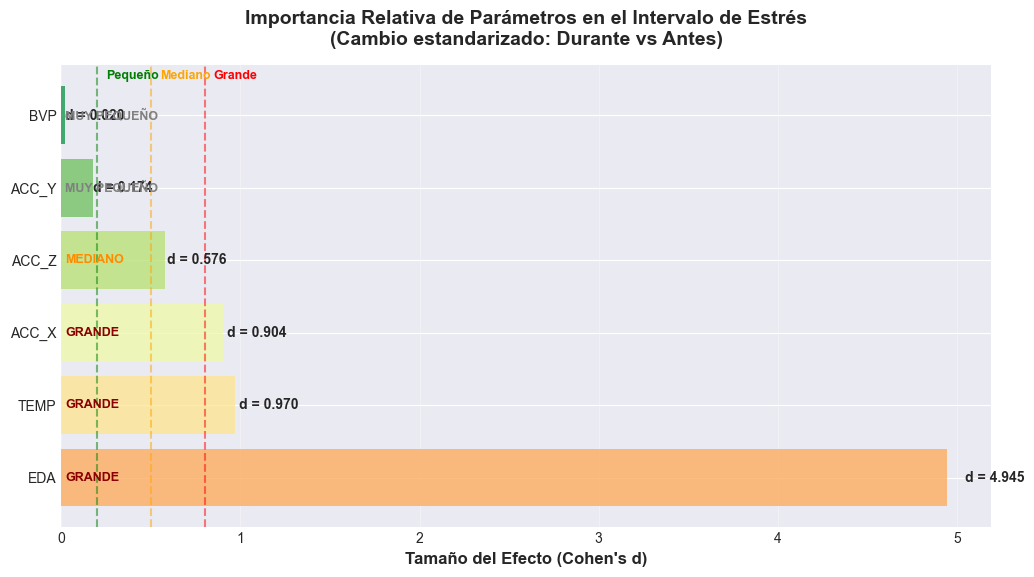


RESUMEN DE IMPORTANCIA PARA ESTE INTERVALO:
EDA: d = 4.945 → MUY IMPORTANTE
TEMP: d = 0.970 → MUY IMPORTANTE
ACC_X: d = 0.904 → MUY IMPORTANTE
ACC_Z: d = 0.576 → IMPORTANTE
ACC_Y: d = 0.174 → POCO IMPORTANTE
BVP: d = 0.020 → POCO IMPORTANTE

ANÁLISIS COMPLETADO
Se analizaron 3 intervalos de estrés.


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')

def visualizar_intervalo_unico(df, intervalo_idx=None, intervalo_especifico=None, ventana_contexto=50):
    
    if intervalo_especifico is not None:
        inicio, fin = intervalo_especifico
        intervalo_idx = 0
    else:
        intervalos = identificar_intervalos_estres(df, min_duracion=5)
        
        if len(intervalos) == 0:
            print("No se encontraron intervalos de estrés significativos.")
            return None
        
        if intervalo_idx is None:
            intervalo_idx = 0
            print(f"Usando el primer intervalo (índice {intervalo_idx})")
        
        if intervalo_idx >= len(intervalos):
            print(f"Índice {intervalo_idx} fuera de rango. Hay {len(intervalos)} intervalos.")
            return None
        
        inicio, fin = intervalos[intervalo_idx]
    
    print(f"\n{'='*70}")
    print(f"ANÁLISIS DETALLADO DEL INTERVALO {intervalo_idx + 1}")
    print(f"{'='*70}")
    print(f"Intervalo: muestras {inicio} a {fin} (duración: {fin - inicio} muestras)")
    
    inicio_contexto = max(0, inicio - ventana_contexto)
    fin_contexto = min(len(df), fin + ventana_contexto)
    intervalo_completo_df = df.iloc[inicio_contexto:fin_contexto].copy()
    
    tiempo_relativo = np.arange(len(intervalo_completo_df)) - (inicio - inicio_contexto)
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 1, hspace=0.4)
    
    ax1 = fig.add_subplot(gs[0])
    for i, col in enumerate(['acc_x', 'acc_y', 'acc_z']):
        ax1.plot(tiempo_relativo, intervalo_completo_df[col], 
                label=col.upper(), color=plt.cm.Set1(i), alpha=0.8, linewidth=1.5)
    
    ax1.axvspan(0, fin - inicio, alpha=0.2, color='red', label='Estrés (stress=1)')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax1.axvline(x=fin - inicio, color='red', linestyle='--', alpha=0.5)
    
    ax1.set_xlabel('Muestras relativas al inicio del estrés')
    ax1.set_ylabel('Aceleración')
    ax1.set_title('Comportamiento del Acelerómetro')
    ax1.legend(loc='upper right', ncol=4)
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[1])
    if 'bvp' in intervalo_completo_df.columns:
        ax2.plot(tiempo_relativo, intervalo_completo_df['bvp'], 
                label='BVP', color='purple', linewidth=2)
    
    ax2b = ax2.twinx()
    if 'eda' in intervalo_completo_df.columns:
        ax2b.plot(tiempo_relativo, intervalo_completo_df['eda'], 
                 label='EDA', color='green', linewidth=2, alpha=0.7)
    
    ax2.axvspan(0, fin - inicio, alpha=0.2, color='red')
    ax2.set_xlabel('Muestras relativas al inicio del estrés')
    ax2.set_ylabel('BVP', color='purple')
    ax2b.set_ylabel('EDA', color='green')
    ax2.set_title('Volumen de Pulso Sanguíneo (BVP) y Actividad Electrodermal (EDA)')
    
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[2])
    if 'temp' in intervalo_completo_df.columns:
        ax3.plot(tiempo_relativo, intervalo_completo_df['temp'], 
                label='Temperatura', color='orange', linewidth=2)
    
    ax3.axvspan(0, fin - inicio, alpha=0.2, color='red')
    ax3.set_xlabel('Muestras relativas al inicio del estrés')
    ax3.set_ylabel('Temperatura (°C)')
    ax3.set_title('Comportamiento de la Temperatura')
    ax3.legend(loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    fig.suptitle(f'Análisis Detallado del Intervalo de Estrés \n'
                f'Muestras {inicio} a {fin} (Duración: {fin - inicio} muestras)', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.subplots_adjust(hspace=0.4, top=0.92)
    plt.show()
    
    print(f"\n{'='*70}")
    print("ANÁLISIS ESTADÍSTICO DETALLADO")
    print(f"{'='*70}")
    
    periodo_antes = intervalo_completo_df[tiempo_relativo < 0]
    periodo_durante = intervalo_completo_df[(tiempo_relativo >= 0) & (tiempo_relativo <= (fin - inicio))]
    periodo_despues = intervalo_completo_df[tiempo_relativo > (fin - inicio)]
    
    periodos = [periodo_antes, periodo_durante, periodo_despues]
    nombres_periodos = ['Antes', 'Durante', 'Después']
    
    print(f"\nDuración de cada período:")
    print(f"  Antes del estrés: {len(periodo_antes)} muestras")
    print(f"  Durante el estrés: {len(periodo_durante)} muestras")
    print(f"  Después del estrés: {len(periodo_despues)} muestras")
    
    print(f"\n{'='*70}")
    print("ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO:")
    print(f"{'='*70}")
    
    params_comparacion = ['acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp']
    
    for param in params_comparacion:
        if param in intervalo_completo_df.columns:
            print(f"\n{param.upper()}:")
            print(f"{'Período':<10} {'Media':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
            print("-" * 50)
            
            for periodo, nombre in zip(periodos, nombres_periodos):
                if len(periodo) > 0:
                    datos = periodo[param].dropna()
                    if len(datos) > 0:
                        print(f"{nombre:<10} {datos.mean():<10.2f} {datos.std():<10.2f} "
                              f"{datos.min():<10.2f} {datos.max():<10.2f}")
    
    print(f"\n{'='*70}")
    print("TESTS ESTADÍSTICOS (Durante vs Antes):")
    print(f"{'='*70}")
    
    for param in params_comparacion:
        if param in intervalo_completo_df.columns:
            datos_antes = periodo_antes[param].dropna()
            datos_durante = periodo_durante[param].dropna()
            
            if len(datos_antes) > 1 and len(datos_durante) > 1:
                t_stat, p_value = stats.ttest_ind(datos_durante, datos_antes, equal_var=False)
                
                n1, n2 = len(datos_durante), len(datos_antes)
                sd_pooled = np.sqrt(((n1-1)*datos_durante.std()**2 + (n2-1)*datos_antes.std()**2) / (n1+n2-2))
                cohens_d = (datos_durante.mean() - datos_antes.mean()) / sd_pooled
                
                if p_value < 0.001:
                    significancia = "*** (p < 0.001)"
                elif p_value < 0.01:
                    significancia = "** (p < 0.01)"
                elif p_value < 0.05:
                    significancia = "* (p < 0.05)"
                else:
                    significancia = "ns (no significativo)"
                
                if abs(cohens_d) < 0.2:
                    efecto = "Muy pequeño"
                elif abs(cohens_d) < 0.5:
                    efecto = "Pequeño"
                elif abs(cohens_d) < 0.8:
                    efecto = "Mediano"
                else:
                    efecto = "Grande"
                
                print(f"\n{param.upper()}:")
                print(f"  t = {t_stat:.3f}, p = {p_value:.4f} {significancia}")
                print(f"  Cohen's d = {cohens_d:.3f} ({efecto})")
                print(f"  Cambio: {datos_durante.mean() - datos_antes.mean():+.2f} "
                      f"({(datos_durante.mean()/datos_antes.mean()-1)*100:+.1f}%)")
    
    if len(periodo_durante) > 10:
        print(f"\n{'='*70}")
        print("CORRELACIONES DURANTE EL ESTRÉS:")
        print(f"{'='*70}")
        
        params_corr = [p for p in params_comparacion if p in periodo_durante.columns]
        if len(params_corr) >= 2:
            corr_matrix = periodo_durante[params_corr].corr()
            
            print("\nMatriz de correlación:")
            print(" " * 10 + "".join([f"{p:>10}" for p in params_corr]))
            for i, p1 in enumerate(params_corr):
                row = f"{p1:10}"
                for j, p2 in enumerate(params_corr):
                    corr_val = corr_matrix.iloc[i, j]
                    row += f"{corr_val:10.3f}"
                print(row)
            
            correlaciones_fuertes = []
            for i in range(len(params_corr)):
                for j in range(i+1, len(params_corr)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.7:
                        correlaciones_fuertes.append((params_corr[i], params_corr[j], corr_val))
            
            if correlaciones_fuertes:
                for p1, p2, corr_val in correlaciones_fuertes:
                    print(f"  {p1.upper()} ↔ {p2.upper()}: r = {corr_val:.3f}")
            else:
                print("  No hay correlaciones fuertes durante este intervalo")
    
    return {
        'intervalo': (inicio, fin),
        'datos_completos': intervalo_completo_df,
        'periodo_antes': periodo_antes,
        'periodo_durante': periodo_durante,
        'periodo_despues': periodo_despues,
        'tiempo_relativo': tiempo_relativo
    }

def graficar_importancia_intervalo_unico(resultados_analisis):

    if resultados_analisis is None:
        print("No hay resultados para analizar.")
        return
    
    periodo_durante = resultados_analisis['periodo_durante']
    periodo_antes = resultados_analisis['periodo_antes']
    
    if len(periodo_durante) == 0 or len(periodo_antes) == 0:
        print("Datos insuficientes para análisis de importancia.")
        return
    
    parametros = ['acc_x', 'acc_y', 'acc_z', 'bvp', 'eda', 'temp']
    diferencias = []
    nombres = []
    
    for param in parametros:
        if param in periodo_durante.columns and param in periodo_antes.columns:
            datos_durante = periodo_durante[param].dropna()
            datos_antes = periodo_antes[param].dropna()
            
            if len(datos_durante) > 0 and len(datos_antes) > 0:
                mean_diff = datos_durante.mean() - datos_antes.mean()
                std_pooled = np.sqrt((datos_durante.std()**2 + datos_antes.std()**2) / 2)
                
                if std_pooled > 0:
                    d = abs(mean_diff / std_pooled)
                else:
                    d = 0
                
                diferencias.append(d)
                nombres.append(param.upper())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if diferencias:
        indices_ordenados = np.argsort(diferencias)[::-1]
        diferencias_ordenadas = [diferencias[i] for i in indices_ordenados]
        nombres_ordenados = [nombres[i] for i in indices_ordenados]
        
        colores = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(diferencias)))
        
        bars = ax.barh(nombres_ordenados, diferencias_ordenadas, color=colores, alpha=0.8)
        
        for i, (bar, d_val) in enumerate(zip(bars, diferencias_ordenadas)):
            ax.text(bar.get_width() * 1.02, bar.get_y() + bar.get_height()/2,
                   f'd = {d_val:.3f}', va='center', fontsize=10, fontweight='bold')
            
            if d_val >= 0.8:
                efecto = "GRANDE"
                color_texto = 'darkred'
            elif d_val >= 0.5:
                efecto = "MEDIANO"
                color_texto = 'darkorange'
            elif d_val >= 0.2:
                efecto = "PEQUEÑO"
                color_texto = 'darkgreen'
            else:
                efecto = "MUY PEQUEÑO"
                color_texto = 'gray'
            
            ax.text(0.02, bar.get_y() + bar.get_height()/2, efecto,
                   va='center', fontsize=9, color=color_texto, fontweight='bold')
        
        ax.set_xlabel('Tamaño del Efecto (Cohen\'s d)', fontsize=12, fontweight='bold')
        ax.set_title('Importancia Relativa de Parámetros en el Intervalo de Estrés\n'
                    '(Cambio estandarizado: Durante vs Antes)', 
                    fontsize=14, fontweight='bold', pad=15)
        
        for d_val, label, color in [(0.2, 'Pequeño', 'green'), 
                                   (0.5, 'Mediano', 'orange'), 
                                   (0.8, 'Grande', 'red')]:
            ax.axvline(x=d_val, color=color, linestyle='--', alpha=0.5)
            ax.text(d_val + 0.05, len(diferencias) - 0.5, label,
                   color=color, fontsize=9, fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    plt.show()
    
    if diferencias:
        print(f"\n{'='*70}")
        print("RESUMEN DE IMPORTANCIA PARA ESTE INTERVALO:")
        print(f"{'='*70}")
        
        for nombre, d_val in zip(nombres_ordenados, diferencias_ordenadas):
            if d_val >= 0.8:
                importancia = "MUY IMPORTANTE"
            elif d_val >= 0.5:
                importancia = "IMPORTANTE"
            elif d_val >= 0.2:
                importancia = "MODERADAMENTE IMPORTANTE"
            else:
                importancia = "POCO IMPORTANTE"
            
            print(f"{nombre}: d = {d_val:.3f} → {importancia}")

if __name__ == "__main__":
    print("="*70)
    print("ANÁLISIS DE LOS 3 INTERVALOS DE ESTRÉS MÁS LARGOS")
    print("="*70)
    
    if 'df_reduced' not in globals() or len(df_reduced) == 0:
        print("ERROR: df_reduced no está definido o está vacío.")
        if 'df_full' in globals() and len(df_full) > 0:
            print("Usando df_full en su lugar...")
            df_analizar = df_full
        else:
            print("No hay datos disponibles.")
            exit()
    else:
        df_analizar = df_reduced
    
    intervalos = identificar_intervalos_estres(df_analizar, min_duracion=5)
    
    if len(intervalos) == 0:
        print("No se encontraron intervalos de estrés.")
        exit()
    
    print(f"\nSe encontraron {len(intervalos)} intervalos de estrés:")
    
    intervalos_ordenados = sorted(intervalos, key=lambda x: x[1] - x[0], reverse=True)
    
    for i, (inicio, fin) in enumerate(intervalos_ordenados[:10]):
        duracion = fin - inicio
        if i < 3:
            print(f"  Intervalo {i+1} (LARGO): muestras {inicio}-{fin} (duración: {duracion} muestras)")
        else:
            print(f"  Intervalo {i+1}: muestras {inicio}-{fin} (duración: {duracion} muestras)")
    
    if len(intervalos) > 10:
        print(f"  ... y {len(intervalos) - 10} intervalos más")
    
    if len(intervalos_ordenados) < 3:
        print(f"\nNota: Solo hay {len(intervalos_ordenados)} intervalos disponibles.")
        intervalos_seleccionados = intervalos_ordenados
    else:
        intervalos_seleccionados = intervalos_ordenados[:3]
    
    
    for idx, (inicio, fin) in enumerate(intervalos_seleccionados):
        print(f"\n{'='*70}")
        print(f"INTERVALO {idx + 1} de 3")
        print(f"{'='*70}")
        
        resultados = visualizar_intervalo_unico(df_analizar, intervalo_especifico=(inicio, fin))
        
        if resultados is not None:
            print(f"\n{'='*70}")
            print(f"ANÁLISIS DE IMPORTANCIA PARA INTERVALO {idx + 1}")
            print(f"{'='*70}")
            graficar_importancia_intervalo_unico(resultados)
    
    print(f"\n{'='*70}")
    print("ANÁLISIS COMPLETADO")
    print(f"{'='*70}")
    print(f"Se analizaron {len(intervalos_seleccionados)} intervalos de estrés.")